Namespace(batchSize=1, dataroot='data/', cuda=True, GPU_id=[0], n_cpu=0, net='output/net_smcswt.pth')
Generated images 0001 of 0008

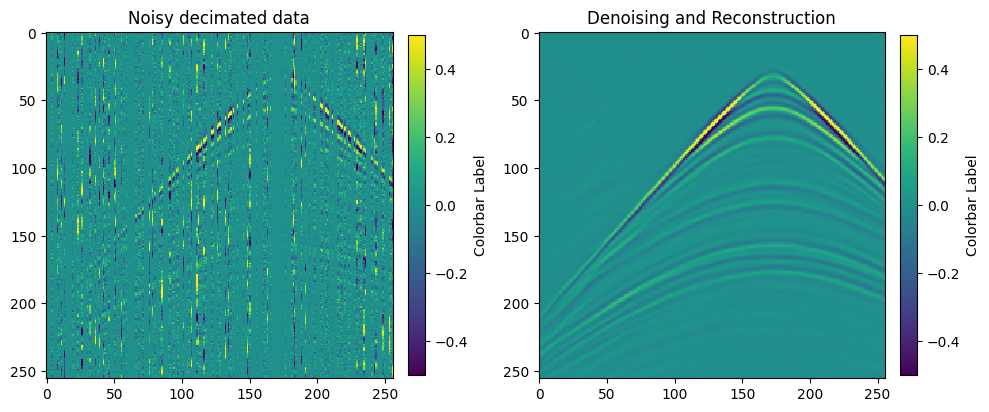

Generated images 0002 of 0008

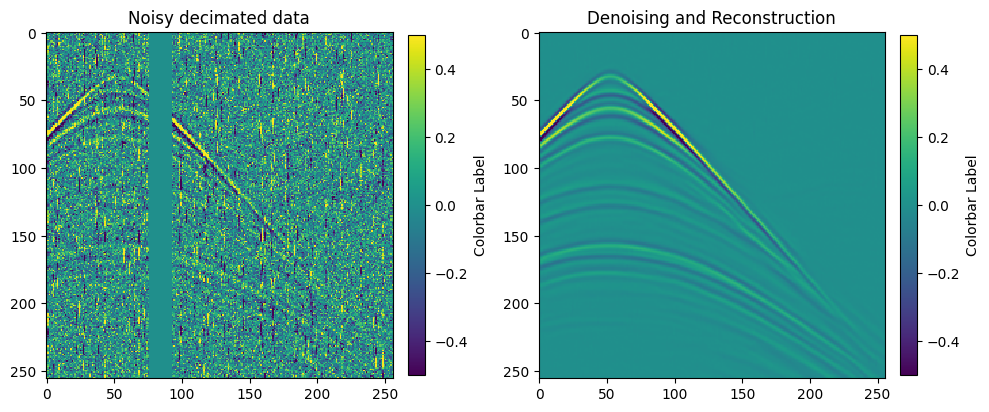

Generated images 0003 of 0008

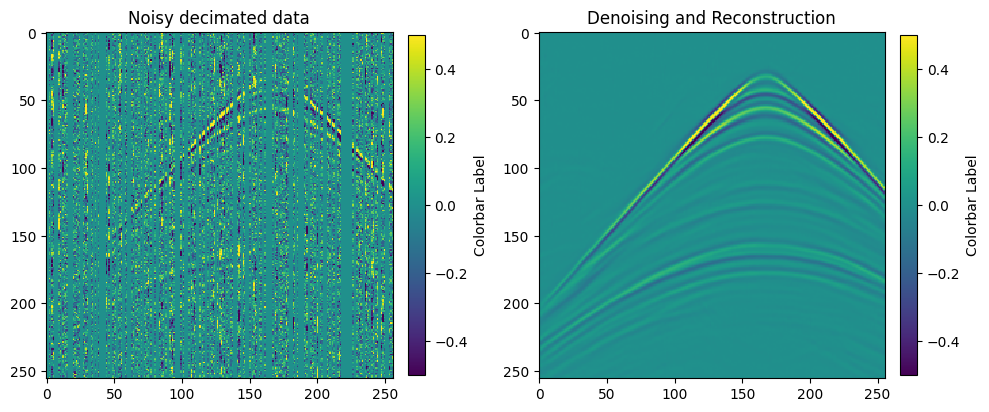

Generated images 0004 of 0008

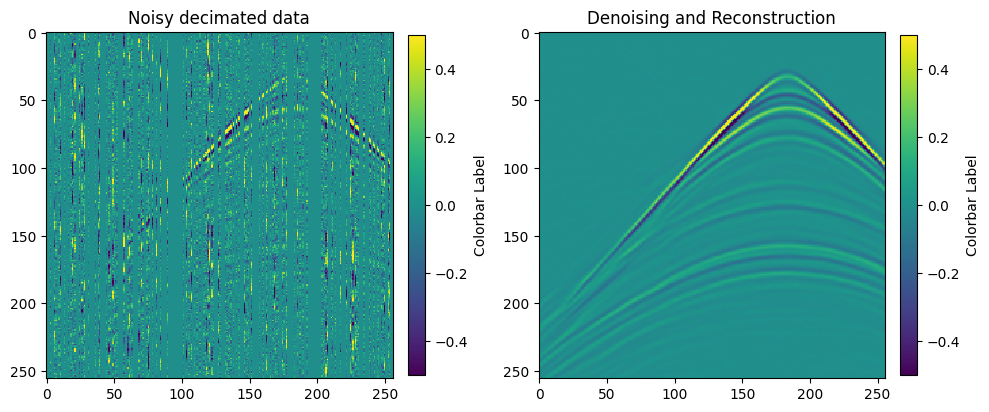

Generated images 0005 of 0008

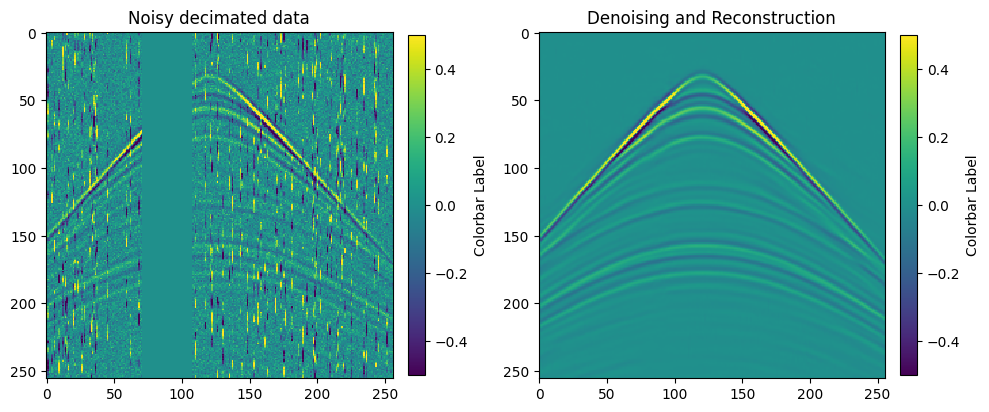

Generated images 0006 of 0008

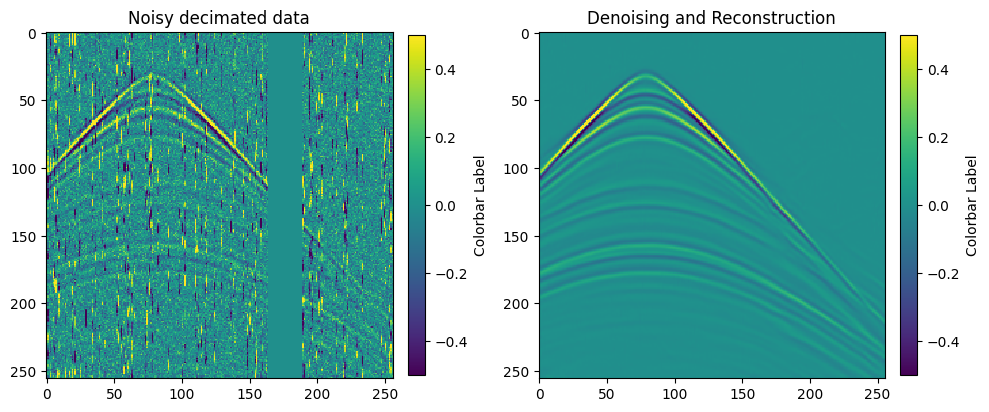

Generated images 0007 of 0008

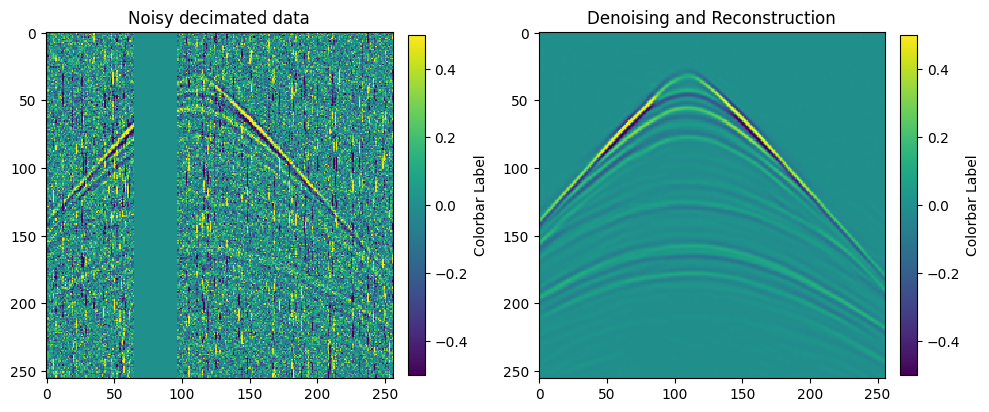

Generated images 0008 of 0008

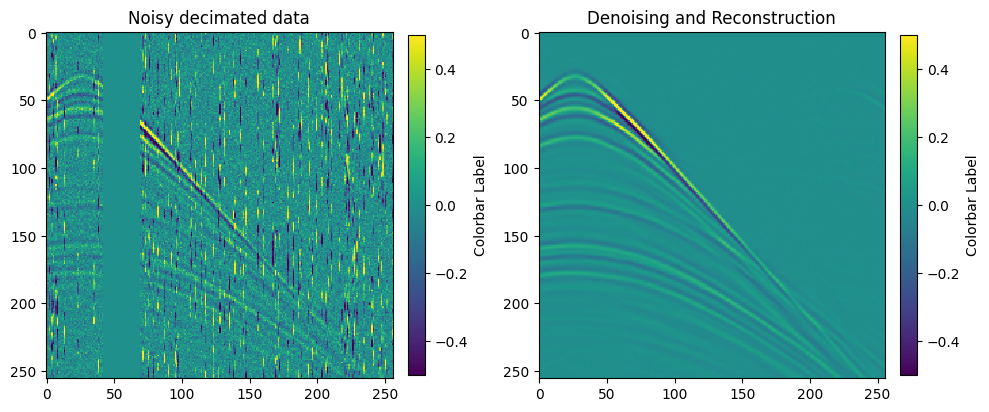

1

In [1]:
#!/usr/bin/python3

import argparse
import sys
import os
import torch.nn as nn
from scipy.io import savemat

from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import matplotlib.pyplot as plt
from models.network import SMCSWT
from models.datasets import Art_nosie_Dataset

parser = argparse.ArgumentParser()
parser.add_argument('--batchSize', type=int, default=1, help='size of the batches')
parser.add_argument('--dataroot', type=str, default='data/', help='root directory of the dataset')

parser.add_argument('--cuda', action='store_true', default=True, help='use GPU computation')
parser.add_argument('--GPU_id', type=str, default=[0], help='Id of GPUs')
parser.add_argument('--n_cpu', type=int, default=0, help='number of cpu threads to use during batch generation')
parser.add_argument('--net', type=str, default='output/net_smcswt.pth', help='file')
opt = parser.parse_known_args()[0]
print(opt)

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

###### Definition of variables ######
Net= SMCSWT(window_size1=[8,8], depth1=[1,1], 
            window_size2=[16,16,16], depth2=[1,1,1], 
            window_size3=[32,32,32,32], depth3=[1,1,1,1])


device_index = opt.GPU_id[0] 
device = torch.device(f'cuda:{device_index}')
device_id = opt.GPU_id
if opt.cuda:
    Net.to(device)
    Net = nn.DataParallel(Net, device_ids=device_id)



# Load state dicts
Net.load_state_dict(torch.load(opt.net, weights_only=True))

# Set model's test mode
Net.eval()


# Dataset loader
dataloader = DataLoader(Art_nosie_Dataset(opt.dataroot, mode='test'), 
                        batch_size=opt.batchSize, shuffle=False, num_workers=opt.n_cpu)
###################################

###### Testing######

# Create output dirs if they don't exist
if not os.path.exists('output/A'):
    os.makedirs('output/A')

for i, batch in enumerate(dataloader):
    # Set model input
    clean = Variable(batch['A'].to(device))
    noisy = Variable(batch['B'].to(device))

    # Generate output
    out = Net(noisy).data

    # Save image files
    save_image(torch.cat((0.5*noisy+0.5,0.5*out+0.5),0), 'output/A/%04d.png' % (i+1))
    sys.stdout.write('\rGenerated images %04d of %04d' % (i+1, len(dataloader)))
    

    fig, axs = plt.subplots(1, 2, figsize=(10, 8))
    
    cax = axs[0].imshow(noisy.cpu().numpy().squeeze(), cmap='viridis', interpolation='nearest', vmin=-.5, vmax=.5)
    axs[0].set_title('Noisy decimated data')
    cbar = fig.colorbar(cax, ax=axs[0], fraction=0.045, pad=0.04, orientation='vertical')
    cbar.set_label('Colorbar Label')

    cax = axs[1].imshow(out.cpu().numpy().squeeze(), cmap='viridis', interpolation='nearest', vmin=-.5, vmax=.5)
    axs[1].set_title('Denoising and Reconstruction')
    cbar = fig.colorbar(cax, ax=axs[1], fraction=0.045, pad=0.04, orientation='vertical')
    cbar.set_label('Colorbar Label')

    plt.tight_layout()
    plt.show()
    

sys.stdout.write('\n')
###################################